# Understanding Decision-focused Learning

## 0. Setup

In [45]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)
np.random.seed(0)

## 1. Data Generation

In [47]:
def make_data(N=4000):
    """
    x1, x2 ~ U(-1,1)
    Reward for two boxes red and blue are defined as:
      base(x) = x1^2 - x2^2
      shift(x) = 100 * (x1 + x2)
      red = base + shift
      blue = -base + shift
    """
    # Uniformly generated features: x1, x2 ~ U(-1,1)
    x = np.random.uniform(-1.0, 1.0, size=(N, 2))
    x1 = x[:, 0]
    x2 = x[:, 1]
    base = x1**2 - x2**2
    shift = 100.0 * (x1 + x2)

    red = base + shift
    blue = -base + shift
    boxes = np.stack([red, blue], axis=1)

    x = torch.from_numpy(x).float().to(device)
    boxes = torch.from_numpy(boxes).float().to(device)

    return x, boxes

## 2. Predictive Model

In [48]:
class MLPRewardModel(nn.Module):
    def __init__(self, hidden_dim=16):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2)
        )

    def forward(self, x):
        return self.net(x)

## 3. Training

In [49]:
def train_test_split(x, box, train_ratio=0.7):
    N = x.shape[0]
    idx = torch.randperm(N)
    train_N = int(train_ratio * N)
    idx_train = idx[:train_N]
    idx_test = idx[train_N:]

    return x[idx_train], box[idx_train], x[idx_test], box[idx_test]


def get_regret(model, x, box_true):
    batch_idx = torch.arange(x.shape[0], device=x.device)
    dec_true = torch.argmax(box_true, dim=1)
    dec_ours = torch.argmax(model(x), dim=1)

    obj_opt = box_true[batch_idx, dec_true]
    obj_ours = box_true[batch_idx, dec_ours]
    regret = (obj_opt - obj_ours).mean().item()

    return regret


def train_pfl(x_train, box_train, epochs=400, lr=0.1):
    # Predictive Model
    model = MLPRewardModel(hidden_dim=16).to(device)
    opt = optim.Adam(model.parameters(), lr=lr)
    hist = {
        "train_pred_loss": [],
        "train_dec_regret": [],
    }
    for epoch in range(epochs):
        box_hat = model(x_train)
        # Prediction Loss
        pred_loss = ((box_hat - box_train) ** 2).mean()
        # Decision Loss
        dec_regret = get_regret(model, x_train, box_train)

        opt.zero_grad()
        pred_loss.backward()
        opt.step()

        if epoch % 10 == 0:
            hist["train_pred_loss"].append(pred_loss.item())
            hist["train_dec_regret"].append(dec_regret)

            print(f"[PFL] Epoch {epoch:03d}"
                  f"\t train L_pred: {pred_loss.item():.4f}"
                  f"\t train R_dec: {dec_regret:.4f}")

    return model, hist


def train_dfl(x_train, box_train, epochs=400, lr=1e-2):
    # Predictive Model
    model = MLPRewardModel(hidden_dim=16).to(device)
    opt = optim.Adam(model.parameters(), lr=lr)
    hist = {
        "train_pred_loss": [],
        "train_dec_regret": [],
    }
    for epoch in range(epochs):
        box_hat = model(x_train)
        # Prediction Loss
        pred_loss = ((box_hat - box_train) ** 2).mean()
        # Decision Loss
        dec_regret = get_regret(model, x_train, box_train)

        # Softmax for DFL
        box_hat_soft = torch.softmax(box_hat, dim=1)

        # Regret = optimal reward - our reward
        # When .backward(), the optimal reward can be ignored because it is constant (does not affect the gradients)
        loss = - (box_hat_soft * box_train).sum(dim=1).mean()

        opt.zero_grad()
        loss.backward()
        opt.step()

        if epoch % 10 == 0:
            hist["train_pred_loss"].append(pred_loss.item())
            hist["train_dec_regret"].append(dec_regret)

            print(f"[DFL] Epoch {epoch:03d}"
                  f"\t train L_pred: {pred_loss.item():.4f}"
                  f"\t train R_dec: {dec_regret:.4f}")
    return model, hist

In [50]:
torch.manual_seed(0)
np.random.seed(0)

x, box_true = make_data(N=6000)
x_train, box_train, x_test, box_test = train_test_split(x, box_true, train_ratio=0.7)

print("=== Training with PFL ===")
pred_model, pred_hist = train_pfl(x_train, box_train)

print("\n=== Training with DFL ===")
dfl_model, dfl_hist = train_dfl(x_train, box_train)

=== Training with PFL ===
[PFL] Epoch 000	 train L_pred: 6496.8052	 train R_dec: 0.3055
[PFL] Epoch 010	 train L_pred: 5214.3486	 train R_dec: 0.3660
[PFL] Epoch 020	 train L_pred: 1766.6255	 train R_dec: 0.3414
[PFL] Epoch 030	 train L_pred: 152.0520	 train R_dec: 0.3346
[PFL] Epoch 040	 train L_pred: 264.8900	 train R_dec: 0.3720
[PFL] Epoch 050	 train L_pred: 69.8227	 train R_dec: 0.3460
[PFL] Epoch 060	 train L_pred: 54.4042	 train R_dec: 0.3346
[PFL] Epoch 070	 train L_pred: 32.8864	 train R_dec: 0.3449
[PFL] Epoch 080	 train L_pred: 18.6740	 train R_dec: 0.3384
[PFL] Epoch 090	 train L_pred: 15.3432	 train R_dec: 0.3353
[PFL] Epoch 100	 train L_pred: 10.7069	 train R_dec: 0.3372
[PFL] Epoch 110	 train L_pred: 7.7893	 train R_dec: 0.3389
[PFL] Epoch 120	 train L_pred: 5.9904	 train R_dec: 0.3721
[PFL] Epoch 130	 train L_pred: 4.6723	 train R_dec: 0.3334
[PFL] Epoch 140	 train L_pred: 3.7127	 train R_dec: 0.3245
[PFL] Epoch 150	 train L_pred: 3.0016	 train R_dec: 0.3042
[PFL] Epoch

## 4. Plot

In [51]:
from matplotlib.colors import ListedColormap

# Red for class 0, Blue for class 1
cmap_rb = ListedColormap(["red", "blue"])

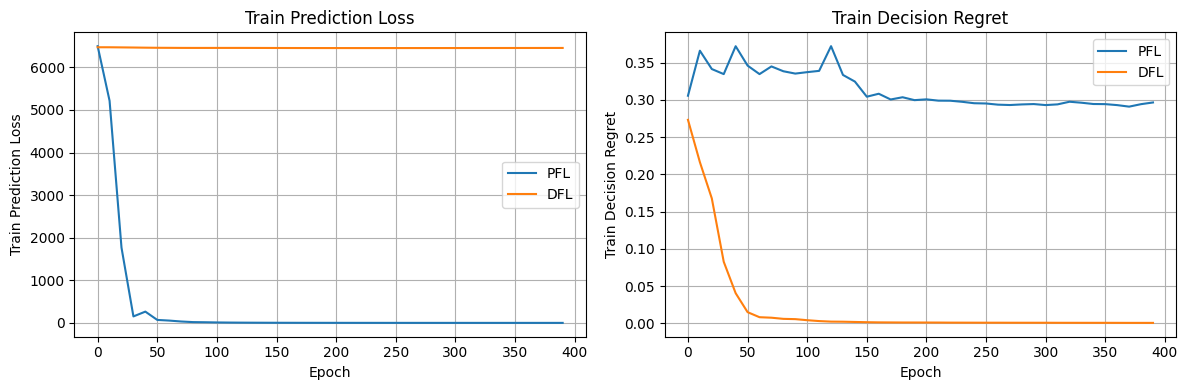

In [52]:
t = np.arange(len(pred_hist["train_pred_loss"])) * 10

plt.figure(figsize=(12, 4))

# Test Prediction Loss
plt.subplot(1, 2, 1)
plt.plot(t, pred_hist["train_pred_loss"], label="PFL")
plt.plot(t, dfl_hist["train_pred_loss"], label="DFL")
plt.xlabel("Epoch")
plt.ylabel("Train Prediction Loss")
plt.title("Train Prediction Loss")
plt.grid(True)
plt.legend()

# Test Decision Loss
plt.subplot(1, 2, 2)
plt.plot(t, pred_hist["train_dec_regret"], label="PFL")
plt.plot(t, dfl_hist["train_dec_regret"], label="DFL")
plt.xlabel("Epoch")
plt.ylabel("Train Decision Regret")
plt.title("Train Decision Regret")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

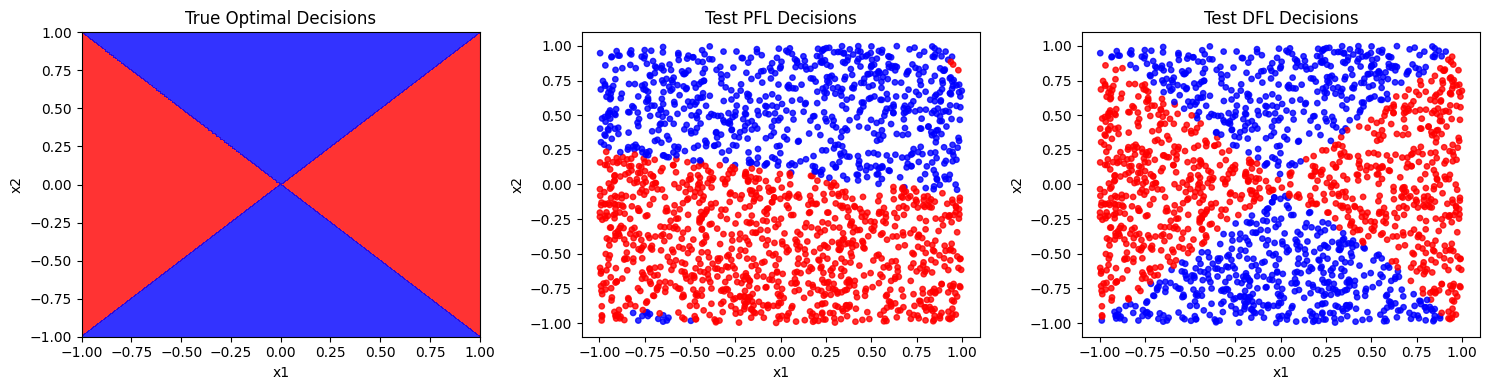

In [53]:
xs = np.linspace(-1, 1, 400)
ys = np.linspace(-1, 1, 400)
x1, x2 = np.meshgrid(xs, ys)

plt.figure(figsize=(15, 4))

# True Optimal Decisions
plt.subplot(1, 3, 1)
# When blue is optimal
true_region = (x1**2 <= x2**2).astype(int)
cs = plt.contourf(
    x1, x2,
    true_region,
    levels=[-0.5, 0.5, 1.5],
    cmap=cmap_rb,
    alpha=0.8,
)
plt.title("True Optimal Decisions")
plt.xlabel("x1")
plt.ylabel("x2")

# Test PFL Decisions
plt.subplot(1, 3, 2)
pfl_idx = torch.argmax(pred_model(x_test), dim=1).cpu().numpy()
plt.scatter(x_test[:, 0], x_test[:, 1], c=pfl_idx, cmap=cmap_rb, s=15, alpha=0.8)
plt.title("Test PFL Decisions")
plt.xlabel("x1")
plt.ylabel("x2")

# Test DFL Decisions
plt.subplot(1, 3, 3)
dfl_idx = torch.argmax(dfl_model(x_test), dim=1).cpu().numpy()
plt.scatter(x_test[:, 0], x_test[:, 1], c=dfl_idx, cmap=cmap_rb, s=15, alpha=0.8)
plt.title("Test DFL Decisions")
plt.xlabel("x1")
plt.ylabel("x2")

plt.tight_layout()
plt.show()